In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
# 1. Calculate the count of missing values for each column
missing_counts = df.isnull().sum()
print("--- Missing Values Count ---")
print(missing_counts)

print("\n" + "="*40 + "\n")

--- Missing Values Count ---
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64




In [4]:
print(df.columns)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


In [5]:
# 2. Categorical Encoding 
#  'sex' (Female=0, Male=1)
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
#  'smoker' (No=0, Yes=1)
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

# Apply One-Hot Encoding to the 'region' column. 
# 'drop_first=True' is used to avoid multicollinearity (Dummy Variable Trap).
df = pd.get_dummies(df, columns=['region'], drop_first=True, dtype=int)
print(f"DataFrame shape after encoding: {df.shape}")

DataFrame shape after encoding: (1338, 9)


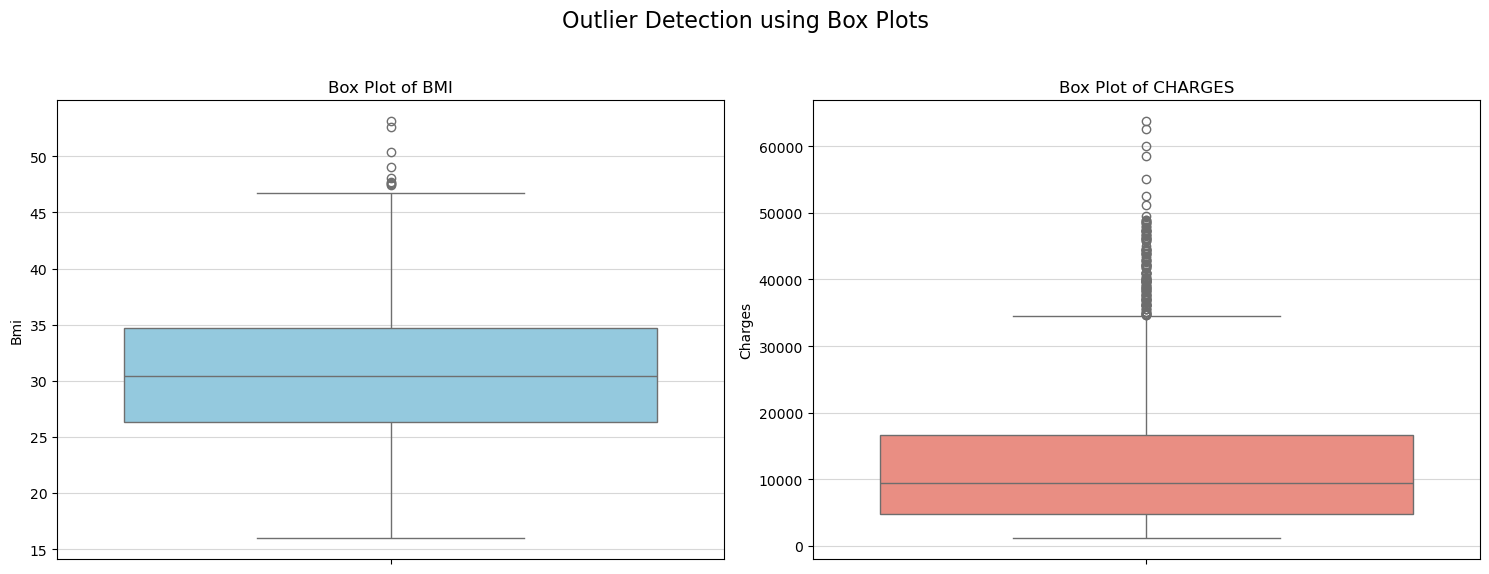

In [6]:

# Define the numerical columns we want to inspect for outliers.
# 'bmi' is a feature we need to clean, and 'charges' is the target variable.
numerical_cols = ['bmi', 'charges']

# Set up the figure size for the plots (we will have two plots side-by-side).
plt.figure(figsize=(15, 6))
plt.suptitle('Outlier Detection using Box Plots', fontsize=16)

# Loop through the columns and create a box plot for each one.
for i, col in enumerate(numerical_cols):
    # Create two subplots in one row (1 row, 2 columns)
    plt.subplot(1, 2, i + 1) 
    
    # Use Seaborn to draw the Box Plot (often cleaner and more aesthetically pleasing)
    sns.boxplot(y=df[col], color='skyblue' if col == 'bmi' else 'salmon') 
    
    plt.title(f'Box Plot of {col.upper()}')
    plt.ylabel(col.capitalize())
    # Add horizontal grid lines for better visualization
    plt.grid(True, axis='y', alpha=0.5) 

# Adjust the plot layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Display the visualization

In [7]:
# 3.Outlier Treatment (BMI) 

# 1. Define the limits for outliers using the Interquartile Range (IQR) method.

Q1_bmi = df['bmi'].quantile(0.25) # Calculate the 1st quartile (25th percentile)
Q3_bmi = df['bmi'].quantile(0.75) # Calculate the 3rd quartile (75th percentile)
IQR_bmi = Q3_bmi - Q1_bmi       # Calculate the Interquartile Range

# Determine the boundaries (1.5 * IQR rule)
lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi

# 2. Apply Capping to the outliers.

# Cap high outliers: Replace values above the upper bound with the upper bound itself.
df['bmi'] = np.where(df['bmi'] > upper_bound_bmi, upper_bound_bmi, df['bmi'])

# Cap low outliers: Replace values below the lower bound with the lower bound itself.
df['bmi'] = np.where(df['bmi'] < lower_bound_bmi, lower_bound_bmi, df['bmi'])

In [8]:
# 4. Normalization/Scaling 

# 4.1 Separate Features (X) from Target (y)

X = df.drop('charges', axis=1) # Independent Variables (Features)
y = df['charges']             # Target Variable

# 4.2 Standardize Independent Numerical Features (X)

numerical_features = ['age', 'bmi', 'children']
scaler_X = StandardScaler()

# Apply Standardization (Z-score: Mean=0, Std=1)
# The BMI column is now clean after Capping, so scaling will be accurate.
X[numerical_features] = scaler_X.fit_transform(X[numerical_features])

In [9]:
# 4.3 Log-Transform and Scale the Target Variable (y)
# The Box Plot showed 'charges' is highly skewed (has many high outliers), 
# so we apply a Log-Transformation to make the distribution closer to normal.
y_log = np.log(y)

# Scale the log-transformed target variable
scaler_y = StandardScaler()
# Note: reshape(-1, 1) is needed because fit_transform expects a 2D array
y_scaled = scaler_y.fit_transform(y_log.values.reshape(-1, 1))

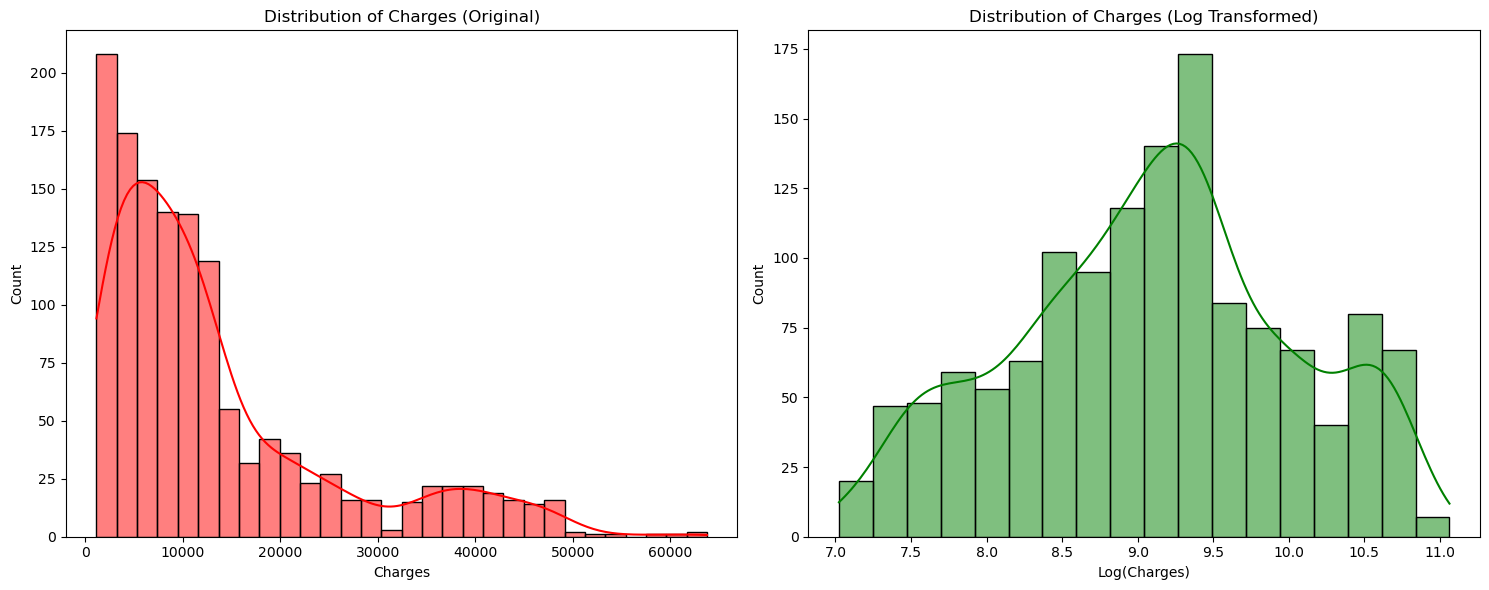

In [10]:
# Set up the figure size for the plots (two plots side-by-side)
plt.figure(figsize=(15, 6))

# Original Distribution (Skewed)
plt.subplot(1, 2, 1) # Create the first subplot (1 row, 2 columns, position 1)
# Use sns.histplot to visualize the distribution of the original 'charges' column
sns.histplot(df['charges'], kde=True, color='red')
plt.title('Distribution of Charges (Original)')
plt.xlabel('Charges')

#  Log-Transformed Distribution (Normalized)
plt.subplot(1, 2, 2) # Create the second subplot (1 row, 2 columns, position 2)
# Apply the Log Transformation (np.log) directly within the plotting function
# This shows the distribution after neutralizing the skewness
sns.histplot(np.log(df['charges']), kde=True, color='green') 
plt.title('Distribution of Charges (Log Transformed)')
plt.xlabel('Log(Charges)')

# Adjust the plot layout for a clean display
plt.tight_layout()
plt.show()

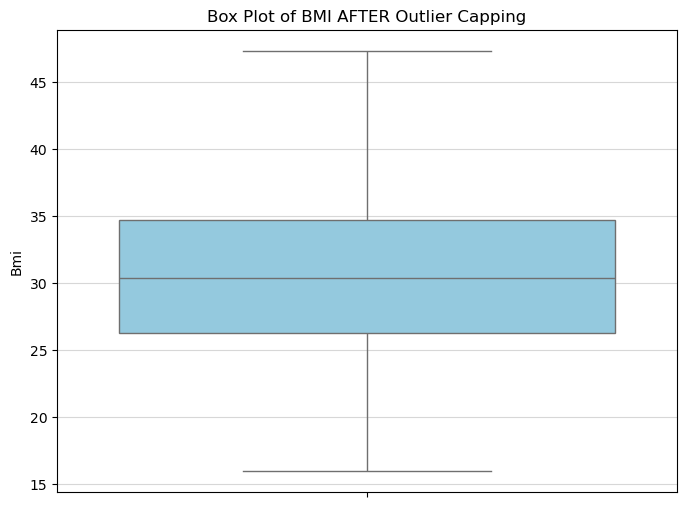

In [11]:

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['bmi'], color='skyblue') 
plt.title('Box Plot of BMI AFTER Outlier Capping')
plt.ylabel('Bmi')
plt.grid(True, axis='y', alpha=0.5)
plt.show()

In [12]:
## Final Preparation Summary
print("\n Final Clean Data Status ")
print("Features X (ready for model):")
print(X.head())
print("\nTarget y_scaled (ready for model):")
print(y_scaled[:5])


 Final Clean Data Status 
Features X (ready for model):
        age  sex       bmi  children  smoker  region_northwest  \
0 -1.438764    0 -0.454201 -0.908614       1                 0   
1 -1.509965    1  0.515300 -0.078767       0                 0   
2 -0.797954    1  0.388125  1.580926       0                 0   
3 -0.441948    1 -1.312218 -0.908614       0                 1   
4 -0.513149    1 -0.292342 -0.908614       0                 1   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0  
2                 1                 0  
3                 0                 0  
4                 0                 0  

Target y_scaled (ready for model):
[[ 0.69139378]
 [-1.79001952]
 [-0.75950049]
 [ 0.97851293]
 [-0.91218124]]


In [13]:

# 5 Data Splitting 
features = X
target = y_scaled    

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.20, 
    random_state=42
)

print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")



Training set size: 1070 rows
Testing set size: 268 rows


In [14]:
# 1. Combine the features (X) with the scaled target variable (y_scaled)
# Create a copy of X and add the 'charges_scaled' column
df_final_cleaned = X.copy()

# Use flatten() to convert y_scaled from a 2D array to a 1D array
df_final_cleaned['charges_scaled'] = y_scaled.flatten()
joblib.dump(scaler_y, 'scaler_y.pkl')
# 2. Save the final cleaned DataFrame as a CSV file
df_final_cleaned.to_csv('insurance_data_cleaned.csv', index=False)
